In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import optuna

In [3]:
import warnings
warnings.filterwarnings('ignore') # ignore warning messages

In [4]:
df = pd.read_csv('Dataset_Complete.csv')

df = df.drop(df.columns[0], axis=1)
df = df[[c for c in df if c not in ['Likes', 'Comments']]
       + ['Likes', 'Comments']]

df

,Username,Followers,Followees,Verification,Business,Business Category,Posts,Caption Token 1,Caption Token 2,Caption Token 3,...,992,993,994,995,996,997,998,999,Likes,Comments
0,153.0,21664800.0,0.0,1.0,0.0,0.0,40.0,42.0,15666.0,1681.0,...,5.707139e-10,5.737810e-08,3.581643e-09,6.208434e-09,2.768166e-08,5.053451e-09,1.294469e-07,1.349951e-04,4786649.0,16258.0
1,153.0,21664800.0,0.0,1.0,0.0,0.0,40.0,1532.0,314.0,547.0,...,1.153214e-05,2.517477e-06,2.839326e-05,9.317895e-06,1.945329e-05,1.079942e-05,4.686316e-04,1.896315e-04,4165277.0,15630.0
2,153.0,21664800.0,0.0,1.0,0.0,0.0,40.0,1169.0,8222.0,318.0,...,1.428277e-05,1.755920e-04,8.948331e-05,1.681776e-04,5.321964e-04,1.767252e-03,4.042462e-04,1.782044e-05,4155201.0,24980.0
3,153.0,21664800.0,0.0,1.0,0.0,0.0,40.0,64.0,5544.0,2156.0,...,1.900617e-05,1.300003e-04,2.013153e-05,9.770014e-05,1.236979e-04,1.917909e-05,1.311907e-04,2.890138e-05,4113889.0,26495.0
4,153.0,21664800.0,0.0,1.0,0.0,0.0,40.0,1026.0,447.0,247.0,...,6.807120e-12,4.441825e-10,2.101302e-10,6.267626e-09,2.846517e-10,1.341658e-11,4.972645e-10,4.478504e-08,4049193.0,15736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,34.0,2996685.0,110.0,1.0,1.0,1.0,433.0,3666.0,12949.0,24344.0,...,3.568996e-04,5.279088e-04,7.427240e-03,4.320456e-03,5.974646e-04,2.292023e-02,6.535090e-04,3.085117e-04,234544.0,989.0
2667,34.0,2996685.0,110.0,1.0,1.0,1.0,433.0,817.0,7985.0,306.0,...,3.335385e-07,6.848353e-06,6.560173e-07,2.739774e-06,4.960687e-06,1.273526e-06,5.739842e-06,1.123541e-04,219879.0,2585.0
2668,34.0,2996685.0,110.0,1.0,1.0,1.0,433.0,32.0,4503.0,3011.0,...,2.337393e-05,2.140431e-04,6.698039e-05,8.347758e-05,1.327411e-04,6.329289e-05,5.350406e-04,8.297876e-04,215286.0,5656.0
2669,34.0,2996685.0,110.0,1.0,1.0,1.0,433.0,25082.0,23078.0,447.0,...,5.226626e-06,6.195489e-05,2.007524e-05,1.998881e-05,2.666036e-05,1.075375e-05,2.137535e-04,6.010067e-04,195725.0,2705.0


In [5]:
# List to store the results
X = []
y_like = []
y_comment = []

# Iterate over each row in the DataFrame
for _, row in df.iterrows():
    row_list = []
    for item in row[:-2]:
        if isinstance(item, list):
            # If the item is a list, extend the row_list with its elements
            row_list.extend(item)
        else:
            # Otherwise, just append the item
            row_list.append(item)
    # Append the processed row to the result list
    X.append(row_list)

y_like = df["Likes"].values.tolist()
y_comment = df["Comments"].values.tolist()

In [6]:
print(f'Lenght of X: {len(X),len(X[0])}  \nSample of X: {X[0]}\n')
print(f'Lenght of y_like: {len(y_like)} \ny_like: {y_like}\n')
print(f'Lenght of y_comment: {len(y_comment)} \ny_comment: {y_comment}')

Lenght of X: (2671, 1064)  
Sample of X: [153.0, 21664800.0, 0.0, 1.0, 0.0, 0.0, 40.0, 42.0, 15666.0, 1681.0, 290.0, 314.0, 389.0, 287.0, 1842.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 50256.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.7510497940520512e-08, 2.292930467717724e-08, 5.732641028544094e-08, 1.9400218320697604e-08, 1.8686702674131086e-07, 2.0609017781225705e-07, 2.0496226937893883e-08, 4.951336762815117e-08, 2.2646819974880827e-09, 9.027580905041075e-10, 2.978378876861143e-09, 6.824403819827295e-10, 1.0588750987139406e-09, 1.0505647463077141e-09, 8.56089588108233e-10, 3.788370506185856e-09, 1.5089659521905219e-09, 2.4868240799946756e-10, 2.922421415973986e

# Instagram Like and Comment Predictors

In [ ]:
X_train_like, X_test_like, y_train_like, y_test_like = train_test_split(X, y_like, test_size=0.1, shuffle = True, random_state=100)

def objective_likes(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "objective": trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror", "reg:gamma"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["auc", "rmse", "mape", "rmsle", "logloss"]),
        "device": trial.suggest_categorical("device", ["cuda"])
    }

    model = XGBRegressor(**params, silent=True)
    model.fit(X_train_like, y_train_like)
    predictions = model.predict(X_test_like)
    mape = mean_absolute_percentage_error(y_test_like, predictions)
    return mape

study_likes = optuna.create_study(direction='minimize')
study_likes.optimize(objective_likes, n_trials=200)

# print('Best hyperparameters:', study_likes.best_params)
# print('Best MAPE score:', study_likes.best_value)

In [9]:
# model_like = XGBRegressor(n_estimators = 350,
#                           learning_rate = 0.02,
#                           max_depth = 5,
#                           subsample = 0.915,
#                           colsample_bytree = 1,
#                           min_child_weight = 2,
#                           objective = 'reg:squarederror',
#                           eval_metric = 'auc',
#                           device = 'cuda')

# model_like = XGBRegressor(n_estimators = 607,
#                           learning_rate = 0.04248586454615846,
#                           max_depth = 6,
#                           subsample = 0.8825881544026494,
#                           colsample_bytree = 0.9692455588139074,
#                           min_child_weight = 11,
#                           objective = 'reg:gamma',
#                           eval_metric = 'logloss',
#                           device = 'cuda')

model_like = XGBRegressor(n_estimators = 937,
                          learning_rate = 0.05319373858101761,
                          max_depth = 7,
                          subsample = 0.9520738932354248,
                          colsample_bytree = 0.9423020222300316,
                          min_child_weight = 21,
                          objective = 'reg:gamma',
                          eval_metric = 'logloss',
                          device = 'cuda')

# cross_val_score(model_like, X, y_like, scoring="neg_mean_absolute_percentage_error", cv = 5)

X_train_like, X_test_like, y_train_like, y_test_like = train_test_split(X, y_like, test_size=0.1, shuffle = True, random_state=100)

model_like.fit(X_train_like,y_train_like)
print(f'MAPE Score for model_like: {mean_absolute_percentage_error(model_like.predict(X_test_like), y_test_like)*100} %')

MAPE Score for model_like: 40.035677920566485 %


In [ ]:
X_train_comment, X_test_comment, y_train_comment, y_test_comment = train_test_split(X, y_comment, test_size=0.1, shuffle = True, random_state=100)

def objective_comments(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 100),
        "objective": trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:absoluteerror"]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["auc", "rmse", "mape", "rmsle", "logloss"]),
        "device": trial.suggest_categorical("device", ["cuda"])
    }

    model = XGBRegressor(**params, silent=True)
    model.fit(X_train_comment, y_train_comment)
    predictions = model.predict(X_test_comment)
    mape = mean_absolute_percentage_error(y_test_comment, predictions)
    return mape

study_comments = optuna.create_study(direction='minimize')
study_comments.optimize(objective_comments, n_trials=200)

# print('Best hyperparameters:', study_comments.best_params)
# print('Best MAPE score:', study_comments.best_value)

In [12]:
# model_comment = XGBRegressor(n_estimators = 350,
#                              learning_rate = 0.02,
#                              max_depth = 5,
#                              subsample = 0.915,
#                              colsample_bytree = 1,
#                              min_child_weight = 2,
#                              objective = 'reg:squarederror',
#                              eval_metric = 'auc',
#                              device = 'cuda')

model_comment = XGBRegressor(n_estimators = 400, #350 - 115%, 129%, 174%, 128%, 103%; 400 - 154%, 105%, 153%, 128%, 84.7%; 450 - 106%, 108%, 118%, 117%, 146%
                             learning_rate = 0.01, #increase is bad; 0.02 -> 0.01
                             max_depth = 7, #5 -> 6 => 80 - 110%; 7 => 80s %; 8 => 80 - 110%
                             subsample = 0.915, #
                             colsample_bytree = 0.7,
                             min_child_weight = 2,
                             objective = 'reg:squarederror',
                             eval_metric = 'auc',
                             device = 'cuda')


# cross_val_score(model_comment, X, y_comment, scoring="neg_mean_absolute_percentage_error", cv = 5)

X_train_comment, X_test_comment, y_train_comment, y_test_comment = train_test_split(X, y_comment, test_size=0.1, shuffle = True, random_state=100)

model_comment.fit(X_train_comment,y_train_comment)
print(f'MAPE Score for model_comment: {mean_absolute_percentage_error(model_comment.predict(X_test_comment), y_test_comment)*100} %')


MAPE Score for model_comment: 82.67691217174524 %


In [13]:
model_like_FULL = model_like
model_like_FULL.fit(X, y_like)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9423020222300316, device='cuda',
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='logloss', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05319373858101761,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=21, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=937, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

In [14]:
model_comment_FULL = model_comment
model_comment_FULL.fit(X, y_comment)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric='auc', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Stable Diffussion Model

In [15]:
!pip install diffusers transformers accelerate scipy safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 34.1 MB/s eta 0:00:00


In [16]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch

model_id = "stabilityai/stable-diffusion-2"

# Use the Euler scheduler here instead
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

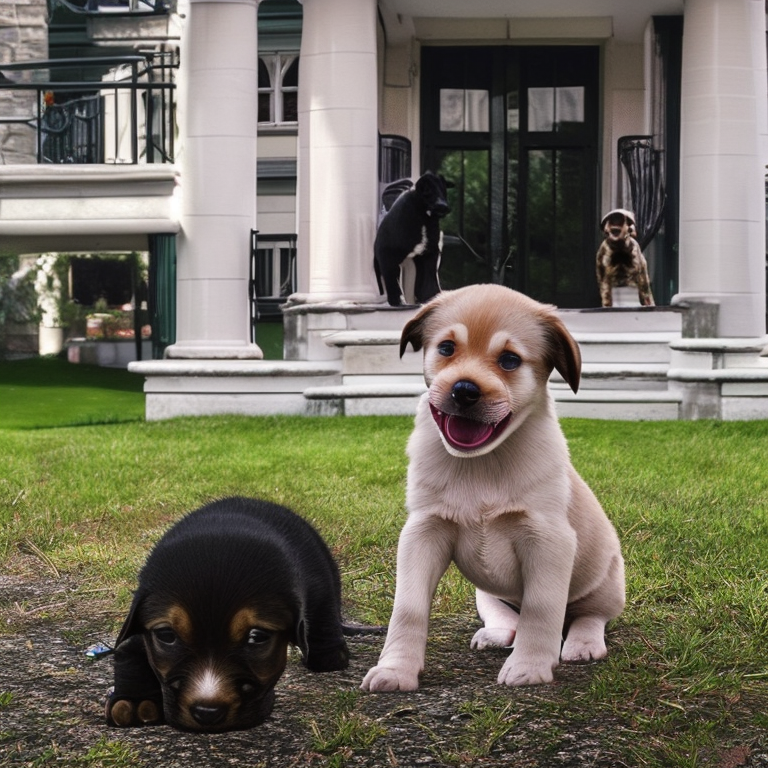

In [24]:
# Example
prompt = "a photo of two puppies playing in the back-yard of a mansion"
image_gen = pipe(prompt).images[0]
image_gen.save("puppies.jpg")
image_gen

# AI Generated Image

In [25]:
df_concat = pd.read_csv('Dataset_Preprocessed.csv')
df_concat = df_concat.drop(df_concat.columns[0], axis=1)

df_concat

,username,followers,followees,is_verified,is_business,business_category,number_of_posts,post_url,caption,hashtags,likes,comments,location,date_utc,img_type
0,meganfox,21664800,0,True,False,NaN,40,https://scontent-dfw5-1.cdninstagram.com/v/t51...,Kourtney and I are in love,[],4786649.0,16258.0,NaN,2021-09-13 20:17:32,GraphImage
1,meganfox,21664800,0,True,False,NaN,40,https://scontent-dfw5-1.cdninstagram.com/v/t51...,If I were the AP Literature teacher at Euphori...,[],4165277.0,15630.0,NaN,2022-01-27 20:56:59,GraphSidecar
2,meganfox,21664800,0,True,False,NaN,40,https://scontent-dfw5-2.cdninstagram.com/v/t51...,the forest is my oldest friend,[],4155201.0,24980.0,NaN,2023-07-15 19:17:48,GraphSidecar
3,meganfox,21664800,0,True,False,NaN,40,https://scontent-dfw5-2.cdninstagram.com/v/t51...,a fourth house taurus sun,[],4113889.0,26495.0,NaN,2023-07-18 19:49:16,GraphSidecar
4,meganfox,21664800,0,True,False,NaN,40,https://scontent-dfw5-1.cdninstagram.com/v/t51...,It’s giving Dracula’s maid,[],4049193.0,15736.0,NaN,2022-02-09 17:16:59,GraphSidecar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,billnye,2996685,110,True,True,None,433,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,My modest telescope and a phone cam. Ours is a...,[],234544.0,989.0,NaN,2019-01-21 07:16:44,GraphImage
2667,billnye,2996685,110,True,True,None,433,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Thoroughly enjoyed this morning’s conversation...,[],219879.0,2585.0,NaN,2018-03-07 04:55:43,GraphImage
2668,billnye,2996685,110,True,True,None,433,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,AOC gets it. She sees that fear is dividing us...,[],215286.0,5656.0,SXSW,2019-03-10 00:39:58,GraphImage
2669,billnye,2996685,110,True,True,None,433,https://instagram.fftw1-1.fna.fbcdn.net/v/t51....,Happy Valentine’s Day 🤷🏻‍♂️,[],195725.0,2705.0,NaN,2019-02-15 01:54:30,GraphImage


## Helper Functions

In [19]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 4.9 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from geopy.geocoders import Photon
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
import torch
import emoji
import re
import cv2
from google.colab.patches import cv2_imshow
from torchvision.io import read_image, ImageReadMode
import torch
from torchvision.io import read_image, ImageReadMode
import torchvision
from torchvision.models import vgg16, VGG16_Weights

In [21]:
def usernanme_encoding(usrn):
  return float(list(np.unique(df_concat['username'])).index(usrn) + 1)


def business_category_encoding(label):
  list_tmp = list(np.unique(list(df_concat['business_category'])))
  list_tmp.remove('nan')
  list_tmp.insert(0, 'nan')
  list_tmp.remove('None')
  list_tmp.insert(1, 'None')
  return float(list_tmp.index(label))


def caption_tokenizer(tokenizer, caption):
  input_ids = tokenizer(caption,max_length=50, padding='max_length', truncation=True).input_ids
  return input_ids


def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.distinct_emoji_list(s))


def caption_encoding(tokenizer, caption):
  return caption_tokenizer(tokenizer, caption), len(extract_emojis(caption))


def clean_string(input_string):
    # Replace multiple spaces with a single space
    input_string = re.sub(r'\s+', ' ', input_string)

    # Remove everything except alphanumeric characters, underscores, and spaces
    return re.sub(r'[^\w\s]', '', input_string)


def hastags_count(has_list):
  has_list = clean_string(has_list)
  has_list = has_list.split(' ')
  if has_list == [''] : return 0.0
  else: return float(len(has_list))


def get_coordinates(address):
    if address == 'nan':
        return 0.0, 0.0

    geolocator = Photon(user_agent="measurements")

    try:
        location = geolocator.geocode(address)
        if location:
            return location.latitude, location.longitude
        else:
            return 0.0, 0.0
    except (GeocoderTimedOut, GeocoderUnavailable):
        return 0.0, 0.0


def date_encoding(full_date):
  date, hour = full_date.split(' ')
  d = pd.Timestamp(date) # Monday=0 ...

  dict_hour = {0.0: [6, 7, 8, 9, 10, 11, 12],     # Morning   -->  6 am to 12 pm
               1.0: [13, 14, 15, 16, 17],         # Afternoon --> 13 pm to  5 pm
               2.0: [18, 19, 20, 21],             # Evening   -->  6 pm to  9 pm
               3.0: [22, 23, 0, 1, 2, 3, 4, 5] }  # Night     -->  9 pm to  5 am

  whole_hour = int(hour.split(':')[0])
  minutes = int(hour.split(':')[1])
  seconds = int(hour.split(':')[2])

  if (seconds > 30) : minutes += 1
  if (minutes > 30) : whole_hour += 1
  if (whole_hour == 24) : whole_hour = 0

  for key in dict_hour.keys():
    if whole_hour in dict_hour[key] : return float(d.dayofweek), key


def image_type_encoding(img_type):
  return float(list(np.unique(df_concat['img_type'])).index(img_type))


def image_generator(model_VGG, weights, img_path, test_flag=0):
  img_org = cv2.imread(img_path, cv2.IMREAD_UNCHANGED) # original image

  if img_org is None:
    return np.zeros(1000).tolist()

  img_resized = resized = cv2.resize(img_org, (224,224), interpolation = cv2.INTER_AREA) # resize image to 224*224 to be used from VGG-16

  # filename = f"resizedImage-{img_path.strip('.jpg').split('/')[-1]}.jpg"
  filename = "resizedImage.jpg" if test_flag == 0 else "savedImage.jpg"
  cv2.imwrite(filename, img_resized)

  torch_img = read_image(filename,ImageReadMode.RGB)

  preprocess = weights.transforms()
  batch = preprocess(torch_img).unsqueeze(0)
  prediction = model_VGG(batch).squeeze(0).softmax(0)

  if test_flag == 0 : os.remove(filename)

  return prediction.tolist()

In [22]:
def create_datapoint(pipe, model_VGG, weights, tokenizer, df_concat, prof_id, prompt_img, prompt_img_path, caption, has_list, loc, full_date, img_type):

  # Initialise datapoint list
  datapoint = []

  # Username
  datapoint.append(usernanme_encoding(prof_id))

  # Followers
  datapoint.append(float(list(df_concat[df_concat["username"] == prof_id]["followers"])[0]))

  # Followees
  datapoint.append(float(list(df_concat[df_concat["username"] == prof_id]["followees"])[0]))

  # Verification
  datapoint.append(float(list(df_concat[df_concat["username"] == prof_id]["is_verified"])[0]))

  # Business
  datapoint.append(float(list(df_concat[df_concat["username"] == prof_id]["is_business"])[0]))

  # Business Category
  datapoint.append(business_category_encoding(str(list(df_concat[df_concat["username"] == prof_id]["business_category"])[0])))

  # Posts
  datapoint.append(float(list(df_concat[df_concat["username"] == prof_id]["number_of_posts"])[0]))

  # Caption Token & Emojis Count
  cap_tokens, emoj_count = caption_encoding(tokenizer, caption)
  for j, tok in enumerate(cap_tokens, 1):
    datapoint.append(float(tok))
  datapoint.append(float(emoj_count))

  # Hashtags
  datapoint.append(hastags_count(has_list))

  # Latitude & Longitude
  lat, lon = get_coordinates(loc)
  # lat, lon = dict_addresses[loc]
  datapoint.append(lat)
  datapoint.append(lon)

  # Date and Time
  date, time = date_encoding(full_date)
  datapoint.append(date)
  datapoint.append(time)

  # Image Type
  datapoint.append(image_type_encoding(img_type))

  # Tensor Image

  image_gen = pipe(prompt_img).images[0]
  image_gen.save(prompt_img_path)
  vgg_img =  image_generator(model_VGG, weights, prompt_img_path)
  for feat_i in range(len(vgg_img)):
    datapoint.append(vgg_img[feat_i])

  return [datapoint]


## Test Example

In [26]:
# Define VGG-16 Model & Weights
model_VGG = vgg16(pretrained=True)
model_VGG.eval()
weights = VGG16_Weights.DEFAULT

# Define Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("EleutherAI/gpt-neo-2.7B")
tokenizer.pad_token = tokenizer.eos_token

# Define Text_to_Img Model
model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# Define Input Data
prof_id = 'meganfox'
prompt_img = "a photo of two puppies playing in the back-yard of a mansion"
prompt_img_path = "ai-gen-image.jpg"
caption = 'Little dogs playing 🐶🐶🐶' # Empty string: ' '
has_list = '[#dogs, #puppies]' # Empty string: '[]'
loc = 'New York' # Empty string: 'nan'
full_date = '2021-09-13 20:17:32'
img_type = 'GraphImage' # Options: ['GraphImage', 'GraphSidecar']


# Test-Example
test_sample = create_datapoint(pipe, model_VGG, weights, tokenizer, df_concat, prof_id, prompt_img, prompt_img_path, caption, has_list, loc, full_date, img_type)

pred_likes = int(model_like_FULL.predict(test_sample)[0])
pred_comments = int(model_comment_FULL.predict(test_sample)[0])

print(f'Predicted Likes: {pred_likes} & Predicted Comments: {pred_comments}')

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Predicted Likes: 2734149 & Predicted Comments: 18508
